In [7]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend, incrementalDrift
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler    
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV

In [8]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

sgd_onehot_1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder='passthrough')

sgd_onehot_2 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder='passthrough')


onehot4 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1]
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)
hybrid_model2 = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

hybrid_xgb_pipe2 = Pipeline([
    ('preprocessor', onehot4),
    ('regressor', hybrid_model2)
])


sgd_pipe = Pipeline([
    ('preprocessor', sgd_onehot_2),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor())
])


sgd_pipe_online = Pipeline([
    ('preprocessor', sgd_onehot_1),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor())
])

switcher = [hybrid_xgb_pipe, sgd_pipe_online]

In [9]:
def full_run():
    products = []
    customers = []
    for i in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[sgd_pipe, switcher], algorithm_name=["LR", "Model switching"], LearningModes=["Offline", "Online"])
    return thesis


In [10]:
thesis = full_run()

Finished experiment! Elapsed time: 0.08078455924987793, total Elapsed time: 0.08078455924987793, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.0578460693359375, total Elapsed time: 0.13863062858581543, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.058840274810791016, total Elapsed time: 0.19747090339660645, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.06582307815551758, total Elapsed time: 0.263293981552124, Algorithm: LR Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finished experiment! Elapsed time: 0.08477425575256348, total Elapsed time: 0.3480682373046875, Algorithm: LR Type

In [12]:
results = thesis.resultsToDF()

In [13]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                 mean   
Algorithm Drift type        Drift time     Drift magnitude              
LR        Incremental Drift Fully observed Large             4.008333   
                                           Small             3.135833   
                            Half observed  Large             5.625000   
                                           Small             3.678333   
                            Unobserved     Large            11.924167   
                                           Small             4.508333   
          No Drift          No Drift       No Drift          3.055000   
          Sudden Drift      Fully observed Large             4.036667   
                                           Small             3.147500   
                            Half observed  Large             5.135833   
                                           Small             3.280833   
                            Unobserved     Large            15.024167   
                                           Small             4.615000   
          Sudden Shock      3 days         Large             3.170000   
                                           Small             3.032500   
                            7 days         Large             3.210000   
                                           Small             3.085000   
LR_O      Incremental Drift Fully observed Large             4.457500   
                                           Small             3.629167   
                            Half observed  Large             3.990000   
                                           Small             3.368333   
                            Unobserved     Large             4.074167   
                                           Small             3.344167   
          No Drift          No Drift       No Drift          3.467500   
          Sudden Drift      Fully observed Large             4.350000   
                                           Small             3.655000   
                            Half observed  Large             3.845000   
                                           Small             3.395000   
                            Unobserved     Large             4.291667   
                                           Small             3.402500   
          Sudden Shock      3 days         Large             3.760000   
                                           Small             3.532500   
                            7 days         Large             3.790000   
                                           Small             3.597500   

                                                                             \
                                                                  std   min   
Algorithm Drift type        Drift time     Drift magnitude                    
LR        Incremental Drift Fully observed Large             2.563853  2.81   
                                           Small             0.304734  2.98   
                            Half observed  Large             5.531047  2.87   
                                           Small             0.801043  3.10   
                            Unobserved     Large             9.328744  3.53   
                                           Small             1.637475  3.10   
          No Drift          No Drift       No Drift          0.010000  3.04   
          Sudden Drift      Fully observed Large             2.696544  2.76   
                                           Small             0.303588  2.98   
                            Half observed  Large             4.393964  2.85   
                                           Small             0.623297  2.99   
                            Unobserved     Large            12.664304  3.36   
                                           Small             1.795461  3.09   
          Sudden Shock      3 days         Large             0.206720  3.06   
                   

In [8]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,MSE,SMAPE
216,Switcher,0.0,Sudden Drift,Large,Important,Unobserved,2141.143423,30.27
257,Switcher,3.0,Sudden Drift,Large,Important,Unobserved,2109.324766,29.81
52,LR,0.0,Sudden Drift,Large,Important,Unobserved,2065.635284,29.67
134,LR,6.0,Sudden Drift,Large,Important,Unobserved,2068.642374,29.56
298,Switcher,6.0,Sudden Drift,Large,Important,Unobserved,2063.530495,29.50
...,...,...,...,...,...,...,...,...
200,Switcher,NaN,No Drift,No Drift,No Drift,No Drift,16.065908,2.55
323,Switcher,6.0,No Drift,No Drift,No Drift,No Drift,15.463177,2.54
311,Switcher,6.0,Incremental Drift,Small,Unimportant,Fully observed,15.711803,2.53
293,Switcher,6.0,Sudden Drift,Small,Unimportant,Fully observed,15.798491,2.53


Next up is changepoint/drift detection!
Let's start with doing it on a single series and then ramp up complexity to multivariate cases

In [40]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

In [41]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10)
#generateTrend(test_prod, indices=1, magnitude=3)
suddenDrift(test_prod, variables=0, magnitude=3, time=140)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float)

In [42]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index)


In [43]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.9)

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [44]:
changepoint

[BOCPDChangePoint(start_time: 2017-05-20T00:00:00.000000000, end_time: 2017-05-20T00:00:00.000000000, confidence: 0.9789737411774339, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-05-21T00:00:00.000000000, end_time: 2017-05-21T00:00:00.000000000, confidence: 0.9799999940954781, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response)]

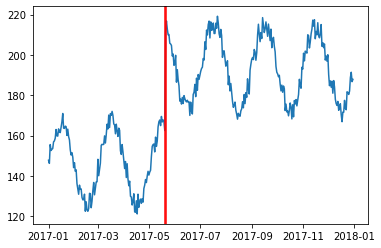

In [45]:
det.plot(changepoint);

In [46]:
test_prod.iloc[[110]]

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-04-21,25.576258,26.605038,2.111045,15.707047,21.914527,23.963883,24.406188,10.019339,30.431647,24.41993,128.512764,2017.0,16.0,5.0
